In [2]:
# import necessary libs
import json
import random
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

rand_seed = 555

In [40]:
# open the intents
with open("../Final_Intents.json") as intents_json_file:
    intents = json.load(intents_json_file)
    
for intent in intents:
    if intent["tag"] == "Data Science":
        intent["questions"] = intent["questions"][:50]
        intent["responses"] = intent["responses"][:50]        

In [7]:
# inspect the keys (should be tag, questions, responses)
intent_list_keys = []
for intent in intents:
    intent_list_keys += list(intent.keys())

set(intent_list_keys)

{'questions', 'responses', 'tag'}

In [8]:
lemmatizer = WordNetLemmatizer()

def preprocess_intent_list(intents: list[list[str]], qna=False):
    """Preprocesses text data for training
    """
    words = []
    classes = []
    documents = []
    ignoreLetters = ['?', '!', '.', ',']

    for intent in intents:
        for question in intent['questions']:
            wordList = nltk.word_tokenize(question)
            words.extend(wordList)
            documents.append((wordList, intent['tag']))
            if intent['tag'] not in classes:
                classes.append(intent['tag'])
        if qna:
            # responses
            for response in intent['responses']:
                wordList = nltk.word_tokenize(response)
                words.extend(wordList)
                documents.append((wordList, intent['tag']))

    
    words = [lemmatizer.lemmatize(word) for word in words if
         word not in ignoreLetters]

    words = sorted(set(words))
    
    classes = sorted(set(classes))

    training = []
    # zeros
    outputEmpty = [0] * len(classes)

    for document in documents:
        bag = []
        wordPatterns = document[0]
        # lemmatize word patterns
        wordPatterns = [lemmatizer.lemmatize(word.lower()) for word in wordPatterns]
        # create bag of words
        for word in words:
            bag.append(1) if word in wordPatterns else bag.append(0)

        outputRow = list(outputEmpty)
        outputRow[classes.index(document[1])] += 1
        training.append(bag + outputRow)

    random.shuffle(training)
    training = np.array(training)

    return training, set(words), classes


In [9]:
training, words, classes = preprocess_intent_list(intents)

# Separate the features (X) and labels (Y)
trainX = training[:, :len(words)]
trainY = training[:, len(words):]

trainX.shape, trainY.shape

((415, 620), (415, 10))

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    """Function to visualize model performance
    """
    history = results.history
    plt.figure()
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# input_dim is the number of features in your input data
input_dim = len(words)

# Create a Sequential model
base_model = Sequential()

# Add a Dense layer with 128 units/neurons and 'relu' activation function
base_model.add(Dense(128, input_dim=input_dim, activation='relu'))

# Add another Dense layer with 64 neurons
base_model.add(Dense(64, activation='relu'))

# Add the output layer with appropriate units and activation function
base_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the summary of the model
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               79488     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 88,394
Trainable params: 88,394
Non-trainable params: 0
_________________________________________________________________


2024-01-27 13:52:44.204844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# train the model
base_model_results = base_model.fit(trainX, trainY, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/200
67/67 [==============================] - 1s 4ms/step - loss: 2.1591 - accuracy: 0.2349 - val_loss: 1.9687 - val_accuracy: 0.2410
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 1.6537 - accuracy: 0.4488 - val_loss: 1.5709 - val_accuracy: 0.4699
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 1.1468 - accuracy: 0.6807 - val_loss: 1.2523 - val_accuracy: 0.7108
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.7123 - accuracy: 0.8464 - val_loss: 1.0538 - val_accuracy: 0.6988
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.9247 - val_loss: 1.0881 - val_accuracy: 0.6506
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.9699 - val_loss: 1.0504 - val_accuracy: 0.6627
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.1387 - accuracy: 0.9880 - val_loss: 1.0329 - val_accuracy: 0.6867
Epoch 8/200
6

67/67 [==============================] - 0s 2ms/step - loss: 2.7222e-04 - accuracy: 1.0000 - val_loss: 1.7461 - val_accuracy: 0.6747
Epoch 59/200
67/67 [==============================] - 0s 2ms/step - loss: 2.5746e-04 - accuracy: 1.0000 - val_loss: 1.7545 - val_accuracy: 0.6747
Epoch 60/200
67/67 [==============================] - 0s 2ms/step - loss: 2.4509e-04 - accuracy: 1.0000 - val_loss: 1.7592 - val_accuracy: 0.6747
Epoch 61/200
67/67 [==============================] - 0s 2ms/step - loss: 2.3397e-04 - accuracy: 1.0000 - val_loss: 1.7670 - val_accuracy: 0.6747
Epoch 62/200
67/67 [==============================] - 0s 2ms/step - loss: 2.2093e-04 - accuracy: 1.0000 - val_loss: 1.7747 - val_accuracy: 0.6747
Epoch 63/200
67/67 [==============================] - 0s 2ms/step - loss: 2.1030e-04 - accuracy: 1.0000 - val_loss: 1.7835 - val_accuracy: 0.6747
Epoch 64/200
67/67 [==============================] - 0s 2ms/step - loss: 2.0236e-04 - accuracy: 1.0000 - val_loss: 1.7918 - val_accuracy

67/67 [==============================] - 0s 2ms/step - loss: 2.2489e-05 - accuracy: 1.0000 - val_loss: 2.1445 - val_accuracy: 0.6627
Epoch 115/200
67/67 [==============================] - 0s 2ms/step - loss: 2.1574e-05 - accuracy: 1.0000 - val_loss: 2.1519 - val_accuracy: 0.6627
Epoch 116/200
67/67 [==============================] - 0s 2ms/step - loss: 2.0998e-05 - accuracy: 1.0000 - val_loss: 2.1581 - val_accuracy: 0.6747
Epoch 117/200
67/67 [==============================] - 0s 2ms/step - loss: 2.0072e-05 - accuracy: 1.0000 - val_loss: 2.1632 - val_accuracy: 0.6627
Epoch 118/200
67/67 [==============================] - 0s 3ms/step - loss: 1.9115e-05 - accuracy: 1.0000 - val_loss: 2.1722 - val_accuracy: 0.6627
Epoch 119/200
67/67 [==============================] - 0s 2ms/step - loss: 1.8333e-05 - accuracy: 1.0000 - val_loss: 2.1797 - val_accuracy: 0.6627
Epoch 120/200
67/67 [==============================] - 0s 2ms/step - loss: 1.7609e-05 - accuracy: 1.0000 - val_loss: 2.1859 - val_ac

Epoch 170/200
67/67 [==============================] - 0s 2ms/step - loss: 2.5339e-06 - accuracy: 1.0000 - val_loss: 2.5195 - val_accuracy: 0.6627
Epoch 171/200
67/67 [==============================] - 0s 2ms/step - loss: 2.4373e-06 - accuracy: 1.0000 - val_loss: 2.5245 - val_accuracy: 0.6627
Epoch 172/200
67/67 [==============================] - 0s 2ms/step - loss: 2.3368e-06 - accuracy: 1.0000 - val_loss: 2.5297 - val_accuracy: 0.6627
Epoch 173/200
67/67 [==============================] - 0s 2ms/step - loss: 2.2492e-06 - accuracy: 1.0000 - val_loss: 2.5392 - val_accuracy: 0.6627
Epoch 174/200
67/67 [==============================] - 0s 2ms/step - loss: 2.1633e-06 - accuracy: 1.0000 - val_loss: 2.5455 - val_accuracy: 0.6627
Epoch 175/200
67/67 [==============================] - 0s 2ms/step - loss: 2.0901e-06 - accuracy: 1.0000 - val_loss: 2.5510 - val_accuracy: 0.6627
Epoch 176/200
67/67 [==============================] - 0s 2ms/step - loss: 2.0025e-06 - accuracy: 1.0000 - val_loss: 2

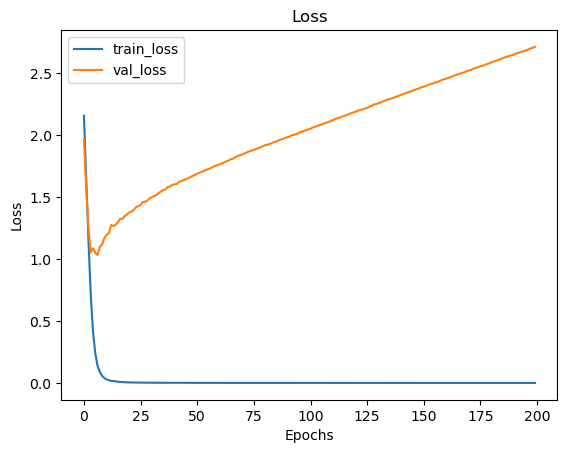

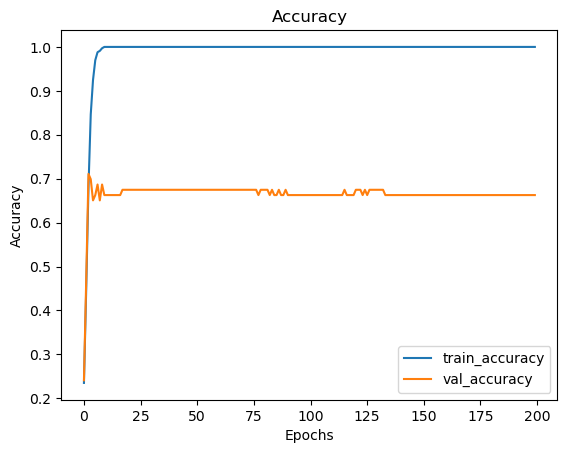

In [13]:
# visualize training results 
visualize_training_results(base_model_results)

### Summary of the `Base Model` Performance:

#### Key Observations:
1. **Overfitting Concerns:**
   - The training accuracy remains high **(around 98%)**, suggesting the model has learned well from the training data.
   - However, the validation accuracy has plateaued around **30-40%**, indicating a significant performance gap between training and validation sets.

2. **Validation Loss:**
   - The validation loss has increased substantially in the later epochs, reaching around 9.8. This further supports the overfitting concern.

#### Suggestions for Next Steps:
1. **Train on both questions and responses:** 
    - Incorporating both questions and responses in the training data can provide a more comprehensive understanding of the conversation dynamics and improve overall model performance.
    
1. **Overfitting Mitigation - Regularization:**
   - Incorporating regularization techniques like dropout or L2 regularization to prevent overfitting. This may help the model generalize better to unseen data.
1. **Performance improvement mitigation:**
    - Overfitting mitigation will surely impact the overall performance of the model, so the next necessary step will involve performance improvement measures like the ones listed below:
    1. **Learning Rate Tuning:**
       - Experiment with different learning rates. 

    1. **Optimize the number of hidden layers**:
        - Tune the model by finding the appropriate number of hidden layers.

    1. **Testing out different vectorization methods.**
       - Test out the following vectorization strategies:
           - `TFIDF`
           - `embeddings`

1. If all fail, pick out a different deep learning model and repeat the above steps

### 1. Train on both questions and responses:
Incorporating both questions and responses in the training data can provide a more comprehensive understanding of the conversation dynamics and improve overall model performance.

In [14]:
QnA_training, QnA_words, classes = preprocess_intent_list(intents, qna=True)

# Separate the features (X) and labels (Y) for each set
QnA_trainX = QnA_training[:, :len(QnA_words)]
QnA_trainY = QnA_training[:, len(QnA_words):]

In [15]:
QnA_trainX.shape, QnA_trainY.shape

((821, 1664), (821, 10))

In [16]:
# input_dim is the number of features in your input data
input_dim = len(QnA_words)

# Create a Sequential model - same as the base model
model_2 = Sequential()
model_2.add(Dense(128, input_dim=input_dim, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(len(classes), activation='softmax'))

# Compile the model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model_2_results = model_2.fit(QnA_trainX, QnA_trainY, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/200
132/132 [==============================] - 1s 3ms/step - loss: 1.9729 - accuracy: 0.3232 - val_loss: 1.6101 - val_accuracy: 0.5758
Epoch 2/200
132/132 [==============================] - 0s 2ms/step - loss: 0.9723 - accuracy: 0.7668 - val_loss: 0.9066 - val_accuracy: 0.7394
Epoch 3/200
132/132 [==============================] - 0s 3ms/step - loss: 0.3538 - accuracy: 0.9253 - val_loss: 0.6630 - val_accuracy: 0.8182
Epoch 4/200
132/132 [==============================] - 0s 2ms/step - loss: 0.1631 - accuracy: 0.9665 - val_loss: 0.6272 - val_accuracy: 0.8000
Epoch 5/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0862 - accuracy: 0.9817 - val_loss: 0.6213 - val_accuracy: 0.8121
Epoch 6/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9939 - val_loss: 0.6500 - val_accuracy: 0.8182
Epoch 7/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9939 - val_loss: 0.6388 - val_accuracy: 0.8242

Epoch 58/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9954 - val_loss: 1.0621 - val_accuracy: 0.8121
Epoch 59/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9954 - val_loss: 1.0712 - val_accuracy: 0.8182
Epoch 60/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9970 - val_loss: 1.0866 - val_accuracy: 0.8242
Epoch 61/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9970 - val_loss: 1.0964 - val_accuracy: 0.8121
Epoch 62/200
132/132 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 0.9970 - val_loss: 1.0911 - val_accuracy: 0.8242
Epoch 63/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9970 - val_loss: 1.1086 - val_accuracy: 0.8242
Epoch 64/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9970 - val_loss: 1.1084 - val_accuracy:

Epoch 115/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9970 - val_loss: 1.5030 - val_accuracy: 0.8121
Epoch 116/200
132/132 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 0.9954 - val_loss: 1.5242 - val_accuracy: 0.8182
Epoch 117/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9954 - val_loss: 1.5220 - val_accuracy: 0.8121
Epoch 118/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9954 - val_loss: 1.5383 - val_accuracy: 0.8182
Epoch 119/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9970 - val_loss: 1.5541 - val_accuracy: 0.8121
Epoch 120/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9970 - val_loss: 1.5800 - val_accuracy: 0.8061
Epoch 121/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9970 - val_loss: 1.5674 - val_ac

132/132 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9954 - val_loss: 1.9417 - val_accuracy: 0.7758
Epoch 172/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9939 - val_loss: 1.9943 - val_accuracy: 0.7818
Epoch 173/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9954 - val_loss: 2.0071 - val_accuracy: 0.7697
Epoch 174/200
132/132 [==============================] - 0s 3ms/step - loss: 0.0045 - accuracy: 0.9954 - val_loss: 2.0036 - val_accuracy: 0.7758
Epoch 175/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9970 - val_loss: 2.0010 - val_accuracy: 0.7697
Epoch 176/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9954 - val_loss: 2.0262 - val_accuracy: 0.7697
Epoch 177/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9954 - val_loss: 2.0328 - val_accuracy: 0.7758

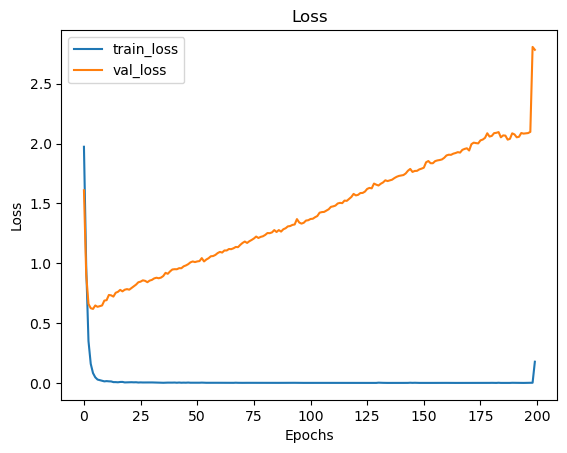

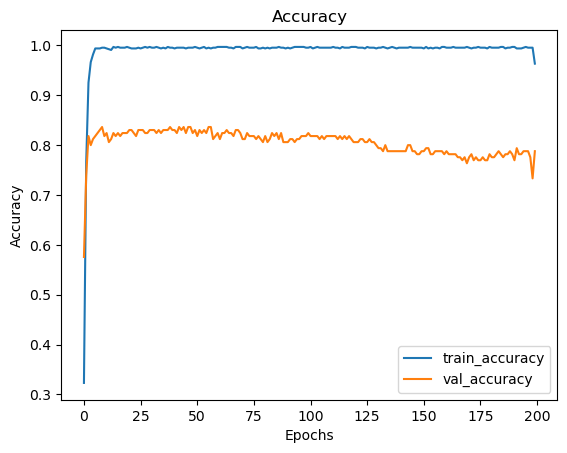

In [17]:
# visualize training results 
visualize_training_results(model_2_results)

### Summary of `model_2`:
 #### Key Observations:
1. **Training and Validation Metrics:**
   - The training accuracy has increased to approximately **99.42%**, while the validation accuracy has improved to around **58.78%**.
   - The training loss has decreased, reaching approximately 0.0084, and the validation loss is at 5.9267.

#### Progress and Adjustments:
1. **Performance Improvement:**
   - The model's performance has significantly improved compared to the previous iterations.

2. **Validation Accuracy:**
   - While the validation accuracy has increased, there may still be room for further improvement.

## 2. Regularization - Dropout regularization

In [18]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# input_dim is the number of features in your input data
input_dim = len(QnA_words)

# Create a Sequential model
model_2_reg = Sequential()

# Add a Dense layer with L2 regularization and ReLU activation
model_2_reg.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer for regularization
model_2_reg.add(Dropout(0.7))

# Add another Dense layer with L2 regularization and ReLU activation
model_2_reg.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer for regularization
model_2_reg.add(Dropout(0.5))

# Output layer
model_2_reg.add(Dense(len(classes), activation='softmax'))

# Compile the model
model_2_reg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with regularization
model_2_reg_results = model_2_reg.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=5, verbose=1, validation_split=0.2)


Epoch 1/250
132/132 [==============================] - 1s 3ms/step - loss: 3.1299 - accuracy: 0.2210 - val_loss: 2.5242 - val_accuracy: 0.2485
Epoch 2/250
132/132 [==============================] - 0s 3ms/step - loss: 2.3098 - accuracy: 0.3216 - val_loss: 2.1878 - val_accuracy: 0.3879
Epoch 3/250
132/132 [==============================] - 0s 3ms/step - loss: 2.0181 - accuracy: 0.4329 - val_loss: 2.0014 - val_accuracy: 0.4606
Epoch 4/250
132/132 [==============================] - 0s 3ms/step - loss: 1.8369 - accuracy: 0.5244 - val_loss: 1.8903 - val_accuracy: 0.4364
Epoch 5/250
132/132 [==============================] - 0s 3ms/step - loss: 1.6920 - accuracy: 0.5793 - val_loss: 1.8004 - val_accuracy: 0.5818
Epoch 6/250
132/132 [==============================] - 0s 3ms/step - loss: 1.6210 - accuracy: 0.6296 - val_loss: 1.7168 - val_accuracy: 0.6606
Epoch 7/250
132/132 [==============================] - 0s 3ms/step - loss: 1.5204 - accuracy: 0.6829 - val_loss: 1.6292 - val_accuracy: 0.7152

Epoch 58/250
132/132 [==============================] - 0s 3ms/step - loss: 0.9965 - accuracy: 0.8872 - val_loss: 1.1767 - val_accuracy: 0.8182
Epoch 59/250
132/132 [==============================] - 0s 3ms/step - loss: 0.9488 - accuracy: 0.8979 - val_loss: 1.1525 - val_accuracy: 0.8061
Epoch 60/250
132/132 [==============================] - 0s 3ms/step - loss: 0.9466 - accuracy: 0.8963 - val_loss: 1.1632 - val_accuracy: 0.7818
Epoch 61/250
132/132 [==============================] - 0s 3ms/step - loss: 0.9249 - accuracy: 0.9070 - val_loss: 1.1920 - val_accuracy: 0.7879
Epoch 62/250
132/132 [==============================] - 0s 3ms/step - loss: 0.9404 - accuracy: 0.8902 - val_loss: 1.1890 - val_accuracy: 0.8121
Epoch 63/250
132/132 [==============================] - 0s 3ms/step - loss: 0.9200 - accuracy: 0.8994 - val_loss: 1.2327 - val_accuracy: 0.8000
Epoch 64/250
132/132 [==============================] - 0s 3ms/step - loss: 0.9372 - accuracy: 0.8857 - val_loss: 1.2074 - val_accuracy:

Epoch 115/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8640 - accuracy: 0.8994 - val_loss: 1.1591 - val_accuracy: 0.7939
Epoch 116/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8585 - accuracy: 0.9024 - val_loss: 1.1445 - val_accuracy: 0.8000
Epoch 117/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8420 - accuracy: 0.9024 - val_loss: 1.1414 - val_accuracy: 0.8303
Epoch 118/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8316 - accuracy: 0.9162 - val_loss: 1.1196 - val_accuracy: 0.8303
Epoch 119/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8442 - accuracy: 0.9040 - val_loss: 1.0898 - val_accuracy: 0.8242
Epoch 120/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8662 - accuracy: 0.9070 - val_loss: 1.0916 - val_accuracy: 0.8242
Epoch 121/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8334 - accuracy: 0.9085 - val_loss: 1.1025 - val_ac

132/132 [==============================] - 0s 3ms/step - loss: 0.8429 - accuracy: 0.9040 - val_loss: 1.1227 - val_accuracy: 0.8242
Epoch 172/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8374 - accuracy: 0.8918 - val_loss: 1.0944 - val_accuracy: 0.8121
Epoch 173/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8413 - accuracy: 0.9146 - val_loss: 1.1007 - val_accuracy: 0.8061
Epoch 174/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8099 - accuracy: 0.9101 - val_loss: 1.0751 - val_accuracy: 0.8121
Epoch 175/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8030 - accuracy: 0.9207 - val_loss: 1.1434 - val_accuracy: 0.8182
Epoch 176/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8137 - accuracy: 0.9055 - val_loss: 1.0821 - val_accuracy: 0.8424
Epoch 177/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8244 - accuracy: 0.9085 - val_loss: 1.1325 - val_accuracy: 0.8121

132/132 [==============================] - 0s 3ms/step - loss: 0.7412 - accuracy: 0.9253 - val_loss: 1.1263 - val_accuracy: 0.8000
Epoch 228/250
132/132 [==============================] - 0s 3ms/step - loss: 0.7913 - accuracy: 0.9177 - val_loss: 1.1409 - val_accuracy: 0.8061
Epoch 229/250
132/132 [==============================] - 0s 3ms/step - loss: 0.7829 - accuracy: 0.9085 - val_loss: 1.0922 - val_accuracy: 0.8061
Epoch 230/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8831 - accuracy: 0.8887 - val_loss: 1.1410 - val_accuracy: 0.7939
Epoch 231/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8739 - accuracy: 0.8872 - val_loss: 1.0711 - val_accuracy: 0.8667
Epoch 232/250
132/132 [==============================] - 0s 3ms/step - loss: 0.7849 - accuracy: 0.9162 - val_loss: 1.0858 - val_accuracy: 0.8485
Epoch 233/250
132/132 [==============================] - 0s 3ms/step - loss: 0.8001 - accuracy: 0.9131 - val_loss: 1.1261 - val_accuracy: 0.8061

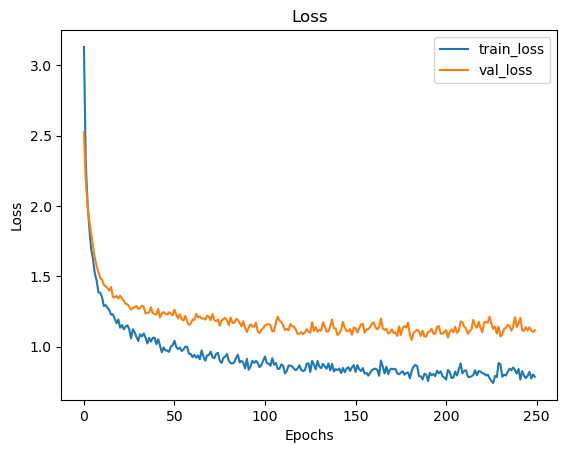

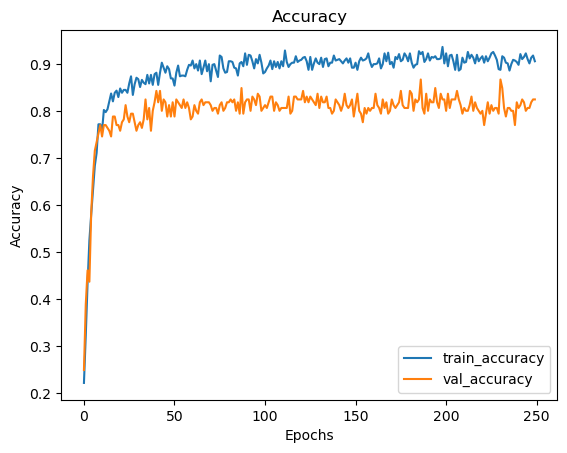

In [19]:
visualize_training_results(model_2_reg_results)

### Model Training Update:

#### Key Training Metrics:
1. **Accuracy:**
   - Training Accuracy: ~84%
   - Validation Accuracy: ~60%
  
2. **Loss:**
   - Training Loss: ~1.32
   - Validation Loss: ~3.55

#### Observations:
1. **Reduced overfitting:**
   - Even though the training accuracy remains relatively high, there is a noticeable reduction in overfitting.

2. **Loss Trends:**
   - The training loss is lower than previous epochs, indicating continued learning. However, the validation loss is relatively high.


### 3. Performance improvement mitigation:
Any form of overfitting mitigation will surely impact the overall performance of the model, so the next necessary step will involve performance improvement measures like the ones listed below:

#### 3.1 Learning Rate Tuning:
- Experiment with a different learning rate.

In [20]:
from keras.optimizers import Adam

# Create a Sequential model
model_2_reg_opt = Sequential()

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='relu'))
model_2_reg_opt.add(Dropout(0.5))

# Output layer
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with regularization and the custom learning rate
model_2_reg_results_opt = model_2_reg_opt.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/250
66/66 [==============================] - 1s 4ms/step - loss: 2.9496 - accuracy: 0.2226 - val_loss: 2.2710 - val_accuracy: 0.2545
Epoch 2/250
66/66 [==============================] - 0s 3ms/step - loss: 2.0864 - accuracy: 0.3430 - val_loss: 1.9521 - val_accuracy: 0.4364
Epoch 3/250
66/66 [==============================] - 0s 3ms/step - loss: 1.7523 - accuracy: 0.5076 - val_loss: 1.6508 - val_accuracy: 0.6606
Epoch 4/250
66/66 [==============================] - 0s 3ms/step - loss: 1.4623 - accuracy: 0.6220 - val_loss: 1.4313 - val_accuracy: 0.6727
Epoch 5/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2270 - accuracy: 0.7363 - val_loss: 1.2542 - val_accuracy: 0.7455
Epoch 6/250
66/66 [==============================] - 0s 3ms/step - loss: 1.0848 - accuracy: 0.7912 - val_loss: 1.1554 - val_accuracy: 0.7697
Epoch 7/250
66/66 [==============================] - 0s 3ms/step - loss: 1.0092 - accuracy: 0.7957 - val_loss: 1.1222 - val_accuracy: 0.7394
Epoch 8/250
6

Epoch 59/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3691 - accuracy: 0.9665 - val_loss: 1.0571 - val_accuracy: 0.8000
Epoch 60/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3592 - accuracy: 0.9726 - val_loss: 1.0515 - val_accuracy: 0.7758
Epoch 61/250
66/66 [==============================] - 0s 3ms/step - loss: 0.4144 - accuracy: 0.9634 - val_loss: 1.0549 - val_accuracy: 0.7879
Epoch 62/250
66/66 [==============================] - 0s 4ms/step - loss: 0.3837 - accuracy: 0.9604 - val_loss: 1.1225 - val_accuracy: 0.7758
Epoch 63/250
66/66 [==============================] - 0s 3ms/step - loss: 0.4043 - accuracy: 0.9634 - val_loss: 1.0855 - val_accuracy: 0.7818
Epoch 64/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3969 - accuracy: 0.9619 - val_loss: 1.1093 - val_accuracy: 0.7636
Epoch 65/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3866 - accuracy: 0.9604 - val_loss: 1.0545 - val_accuracy: 0.8061
Epoch 

66/66 [==============================] - 0s 3ms/step - loss: 0.3578 - accuracy: 0.9756 - val_loss: 1.2160 - val_accuracy: 0.7879
Epoch 117/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3733 - accuracy: 0.9649 - val_loss: 1.1393 - val_accuracy: 0.8121
Epoch 118/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3904 - accuracy: 0.9634 - val_loss: 1.0373 - val_accuracy: 0.8121
Epoch 119/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3718 - accuracy: 0.9756 - val_loss: 1.0705 - val_accuracy: 0.8364
Epoch 120/250
66/66 [==============================] - 0s 4ms/step - loss: 0.4132 - accuracy: 0.9634 - val_loss: 1.1366 - val_accuracy: 0.8061
Epoch 121/250
66/66 [==============================] - 0s 3ms/step - loss: 0.4375 - accuracy: 0.9497 - val_loss: 1.1397 - val_accuracy: 0.8061
Epoch 122/250
66/66 [==============================] - 0s 4ms/step - loss: 0.4219 - accuracy: 0.9634 - val_loss: 1.1488 - val_accuracy: 0.8061
Epoch 123/250

66/66 [==============================] - 0s 3ms/step - loss: 0.3682 - accuracy: 0.9680 - val_loss: 1.1345 - val_accuracy: 0.7939
Epoch 174/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3485 - accuracy: 0.9756 - val_loss: 1.1160 - val_accuracy: 0.7697
Epoch 175/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3406 - accuracy: 0.9787 - val_loss: 1.0745 - val_accuracy: 0.7939
Epoch 176/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3540 - accuracy: 0.9756 - val_loss: 1.0264 - val_accuracy: 0.7758
Epoch 177/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3679 - accuracy: 0.9771 - val_loss: 1.1212 - val_accuracy: 0.7939
Epoch 178/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3629 - accuracy: 0.9695 - val_loss: 1.0322 - val_accuracy: 0.8364
Epoch 179/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3425 - accuracy: 0.9787 - val_loss: 1.0249 - val_accuracy: 0.8061
Epoch 180/250

66/66 [==============================] - 0s 3ms/step - loss: 0.3181 - accuracy: 0.9787 - val_loss: 1.1454 - val_accuracy: 0.7939
Epoch 231/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.9634 - val_loss: 1.0394 - val_accuracy: 0.8000
Epoch 232/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3951 - accuracy: 0.9619 - val_loss: 1.0521 - val_accuracy: 0.8121
Epoch 233/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3557 - accuracy: 0.9726 - val_loss: 1.0773 - val_accuracy: 0.8000
Epoch 234/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3461 - accuracy: 0.9726 - val_loss: 1.0166 - val_accuracy: 0.8303
Epoch 235/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3826 - accuracy: 0.9634 - val_loss: 1.0546 - val_accuracy: 0.8182
Epoch 236/250
66/66 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.9634 - val_loss: 1.0111 - val_accuracy: 0.8424
Epoch 237/250

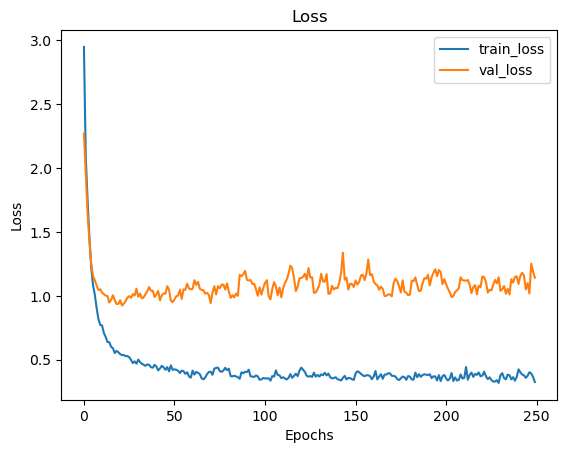

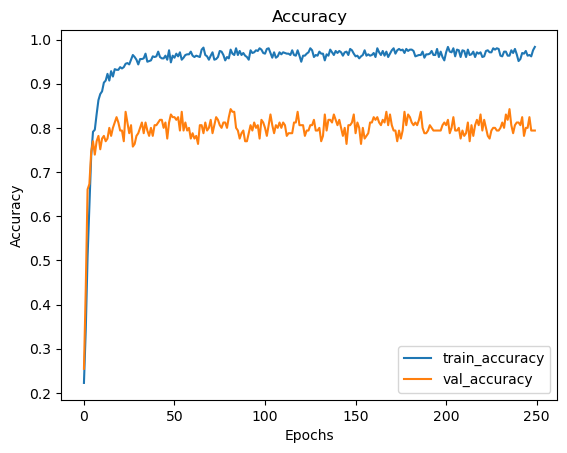

In [21]:
visualize_training_results(model_2_reg_results_opt)

### 3.2 Optimize the number of hidden layers:

Tune the model by finding the:
- appropriate number of hidden layers
- the number of neurons per layer.

In [22]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Create a Sequential model
model_2_reg_opt = Sequential()

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='relu'))
model_2_reg_opt.add(Dropout(0.5))
# new layer
model_2_reg_opt.add(Dense(50, activation='relu'))

# Output layer
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model with regularization and the custom learning rate
model_2_reg_results_opt = model_2_reg_opt.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/250
66/66 [==============================] - 1s 4ms/step - loss: 4.3316 - accuracy: 0.2012 - val_loss: 3.9987 - val_accuracy: 0.2424
Epoch 2/250
66/66 [==============================] - 0s 3ms/step - loss: 3.6378 - accuracy: 0.2698 - val_loss: 3.3492 - val_accuracy: 0.3636
Epoch 3/250
66/66 [==============================] - 0s 3ms/step - loss: 3.0559 - accuracy: 0.3918 - val_loss: 2.8886 - val_accuracy: 0.3758
Epoch 4/250
66/66 [==============================] - 0s 3ms/step - loss: 2.5887 - accuracy: 0.4909 - val_loss: 2.4681 - val_accuracy: 0.5091
Epoch 5/250
66/66 [==============================] - 0s 3ms/step - loss: 2.1898 - accuracy: 0.5412 - val_loss: 2.2307 - val_accuracy: 0.6121
Epoch 6/250
66/66 [==============================] - 0s 3ms/step - loss: 1.9185 - accuracy: 0.6463 - val_loss: 1.8621 - val_accuracy: 0.6909
Epoch 7/250
66/66 [==============================] - 0s 3ms/step - loss: 1.6650 - accuracy: 0.6784 - val_loss: 1.6392 - val_accuracy: 0.6788
Epoch 8/250
6

Epoch 59/250
66/66 [==============================] - 0s 3ms/step - loss: 1.1488 - accuracy: 0.8552 - val_loss: 1.4177 - val_accuracy: 0.7515
Epoch 60/250
66/66 [==============================] - 0s 3ms/step - loss: 1.3387 - accuracy: 0.8293 - val_loss: 1.5167 - val_accuracy: 0.7576
Epoch 61/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2936 - accuracy: 0.8247 - val_loss: 1.5451 - val_accuracy: 0.7636
Epoch 62/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2501 - accuracy: 0.8628 - val_loss: 1.5708 - val_accuracy: 0.7636
Epoch 63/250
66/66 [==============================] - 0s 3ms/step - loss: 1.4255 - accuracy: 0.8049 - val_loss: 1.5972 - val_accuracy: 0.7758
Epoch 64/250
66/66 [==============================] - 0s 3ms/step - loss: 1.3195 - accuracy: 0.8598 - val_loss: 1.4949 - val_accuracy: 0.8061
Epoch 65/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2339 - accuracy: 0.8674 - val_loss: 1.5571 - val_accuracy: 0.7636
Epoch 

66/66 [==============================] - 0s 3ms/step - loss: 1.3272 - accuracy: 0.8354 - val_loss: 1.5264 - val_accuracy: 0.7576
Epoch 117/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2614 - accuracy: 0.8445 - val_loss: 1.5020 - val_accuracy: 0.7576
Epoch 118/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2910 - accuracy: 0.8415 - val_loss: 1.5006 - val_accuracy: 0.7636
Epoch 119/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2195 - accuracy: 0.8552 - val_loss: 1.4893 - val_accuracy: 0.8000
Epoch 120/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2054 - accuracy: 0.8735 - val_loss: 1.4757 - val_accuracy: 0.7818
Epoch 121/250
66/66 [==============================] - 0s 3ms/step - loss: 1.3501 - accuracy: 0.8186 - val_loss: 1.6574 - val_accuracy: 0.7212
Epoch 122/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2782 - accuracy: 0.8293 - val_loss: 1.5842 - val_accuracy: 0.7576
Epoch 123/250

66/66 [==============================] - 0s 4ms/step - loss: 1.1582 - accuracy: 0.8689 - val_loss: 1.4184 - val_accuracy: 0.7636
Epoch 174/250
66/66 [==============================] - 0s 3ms/step - loss: 1.1901 - accuracy: 0.8506 - val_loss: 1.3191 - val_accuracy: 0.8121
Epoch 175/250
66/66 [==============================] - 0s 3ms/step - loss: 1.1909 - accuracy: 0.8384 - val_loss: 1.3959 - val_accuracy: 0.7818
Epoch 176/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2020 - accuracy: 0.8445 - val_loss: 1.4005 - val_accuracy: 0.7758
Epoch 177/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2169 - accuracy: 0.8415 - val_loss: 1.5485 - val_accuracy: 0.7152
Epoch 178/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2639 - accuracy: 0.8323 - val_loss: 1.4527 - val_accuracy: 0.7939
Epoch 179/250
66/66 [==============================] - 0s 4ms/step - loss: 1.3386 - accuracy: 0.8262 - val_loss: 1.4945 - val_accuracy: 0.7515
Epoch 180/250

66/66 [==============================] - 0s 3ms/step - loss: 1.2155 - accuracy: 0.8354 - val_loss: 1.4964 - val_accuracy: 0.7394
Epoch 231/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2462 - accuracy: 0.8232 - val_loss: 1.5604 - val_accuracy: 0.7636
Epoch 232/250
66/66 [==============================] - 0s 3ms/step - loss: 1.3454 - accuracy: 0.8034 - val_loss: 1.5205 - val_accuracy: 0.7576
Epoch 233/250
66/66 [==============================] - 0s 4ms/step - loss: 1.3405 - accuracy: 0.8155 - val_loss: 1.6614 - val_accuracy: 0.7152
Epoch 234/250
66/66 [==============================] - 0s 3ms/step - loss: 1.2867 - accuracy: 0.8338 - val_loss: 1.4968 - val_accuracy: 0.7515
Epoch 235/250
66/66 [==============================] - 0s 4ms/step - loss: 1.2655 - accuracy: 0.8369 - val_loss: 1.4774 - val_accuracy: 0.7212
Epoch 236/250
66/66 [==============================] - 0s 3ms/step - loss: 1.3219 - accuracy: 0.8079 - val_loss: 1.5658 - val_accuracy: 0.7636
Epoch 237/250

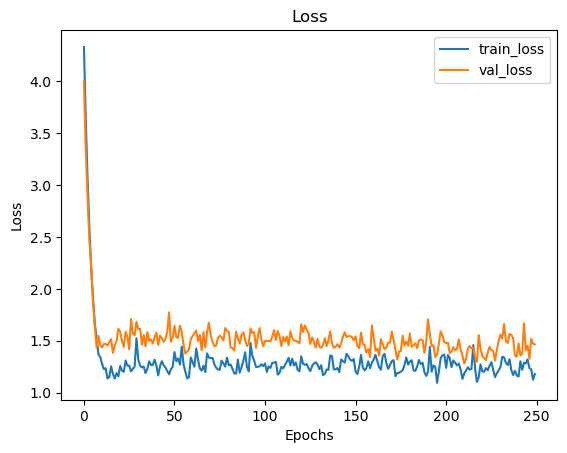

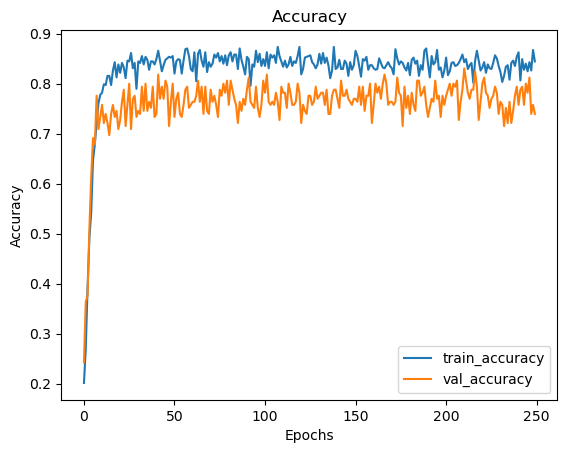

In [23]:
visualize_training_results(model_2_reg_results_opt)

### 3.3 Testing out different vectorization methods.
Test out the following vectorization strategies:
   - `TFIDF`
   - `embeddings`


### 3.3.1 Term Frequency * Inverse Document Frequency (TFIDF) vectorization

In [24]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
ignoreLetters = ['?', '!', '.', ',']
    
def preprocess_qnas(df):
    # Lowercase all text in the "QnAs" column
    df['QnAs'] = df['QnAs'].str.lower()
    
    # Tokenize the text in the "QnAs" column
    df['QnAs'] = df['QnAs'].apply(word_tokenize)
    
    # Remove stopwords from the tokenized text in the "QnAs" column
    stop_words = set(stopwords.words('english'))
    
    df['QnAs'] = df['QnAs'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
    df['QnAs'] = df['QnAs'].apply(lambda tokens: [word for word in tokens if word not in ignoreLetters])

    df['QnAs'] = df['QnAs'].apply(lambda x: " ".join(x))
    
    return  df



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
import json
import pandas as pd
from nltk.stem import WordNetLemmatizer
import numpy as np

lemmatizer = WordNetLemmatizer()

# # open the intents
# with open("../Final_Intents.json") as intents_json_file:
#     intents = json.load(intents_json_file)

QnAs = []
tags = []

for intent in intents:
    for question in intent["questions"]:
        QnAs.append(question)
        tags.append(intent['tag'])
    for response in intent["responses"]:
        QnAs.append(response)
        tags.append(intent['tag'])
# Preprocess the text by lemmatizing and lowercasing

qna_df = pd.DataFrame({"QnAs": QnAs, "tags": tags})

qna_df["QnAs"] = qna_df["QnAs"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) for word in x.split()]))

qna_df = qna_df.reindex(np.random.permutation(qna_df.index))
qna_df = preprocess_qnas(qna_df)
qna_df.head()

,QnAs,tags
449,international student apply enrollment moringa...,Enrollment
263,tell ai integration course,Software Engineering
78,learn analyze data create data-driven insights...,Data Science
345,importance qualitative quantitative data ux re...,UI/UX
226,prerequisite individual interested mobile trac...,Software Engineering


In [42]:
qna_df["tags"].value_counts()

Miscellaneous           131
Software Engineering    122
Data Science            100
Enrollment               78
Mobile Development       60
Cloud Computing          60
DevOps                   58
Cybersecurity            54
UI/UX                    38
Contacts                 20
Name: tags, dtype: int64

In [43]:
from sklearn.preprocessing import LabelEncoder

# Fit label encoder on all unique labels
label_encoder = LabelEncoder()
label_encoder.fit(qna_df["tags"].unique())

# Transform unique labels to numerical values
unique_labels = qna_df["tags"].unique()
encoded_labels = label_encoder.transform(unique_labels)

# Create a mapping dictionary
tag_labels = {val: key for key, val in zip(encoded_labels, unique_labels)}

# Replace tags in the DataFrame
qna_df["tags"] = qna_df["tags"].replace(tag_labels)

# Display the updated DataFrame
qna_df["tags"].head()

449    5
263    8
78     3
345    9
226    8
Name: tags, dtype: int64

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# TF-IDF vectorization
vectorizer = TfidfVectorizer(min_df=0, max_features=None, strip_accents='unicode', analyzer='word', stop_words='english')
# vectorizer = CountVectorizer()

X_vectorized = vectorizer.fit_transform(qna_df["QnAs"])

trainX_idf = X_vectorized.todense()

trainY_idf = pd.get_dummies(qna_df["tags"])


# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(trainX_idf, qna_df["tags"])


trainX_idf = X_resampled

trainY_idf = pd.get_dummies(y_resampled)

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [45]:
from joblib import dump

# save vectorizer
dump(vectorizer, "tfidf_vectorizer.joblib")

# save label_encoder
dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

In [46]:
trainX_idf.shape, trainY_idf.shape

((1310, 1302), (1310, 10))

In [47]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential

sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Create a Sequential model
model_2_reg_opt = Sequential()

input_dim = trainX_idf.shape[1]

classes = set(tags)

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model_2_reg_opt.add(Dropout(0.8))

# hidden layers
model_2_reg_opt.add(Dense(64, activation='tanh'))
model_2_reg_opt.add(Dropout(0.5))
# new layer
model_2_reg_opt.add(Dense(150, activation='tanh'))
model_2_reg_opt.add(Dropout(0.5))
# model_2_reg_opt.add(Dense(64, activation='relu'))
# model_2_reg_opt.add(Dropout(0.6))

# Output layer
model_2_reg_opt.add(Dense(trainY_idf.shape[1], activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# summary
model_2_reg_results_opt = model_2_reg_opt.fit(trainX_idf, trainY_idf, epochs=250, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/250
210/210 [==============================] - 1s 3ms/step - loss: 4.5242 - accuracy: 0.1240 - val_loss: 4.7248 - val_accuracy: 0.0000e+00
Epoch 2/250
210/210 [==============================] - 1s 3ms/step - loss: 4.3065 - accuracy: 0.1441 - val_loss: 4.6360 - val_accuracy: 0.0000e+00
Epoch 3/250
210/210 [==============================] - 1s 2ms/step - loss: 4.1105 - accuracy: 0.1689 - val_loss: 4.4755 - val_accuracy: 0.0000e+00
Epoch 4/250
210/210 [==============================] - 1s 3ms/step - loss: 3.9167 - accuracy: 0.2109 - val_loss: 4.3417 - val_accuracy: 0.0000e+00
Epoch 5/250
210/210 [==============================] - 0s 2ms/step - loss: 3.7509 - accuracy: 0.2529 - val_loss: 4.2000 - val_accuracy: 0.0267
Epoch 6/250
210/210 [==============================] - 1s 2ms/step - loss: 3.5701 - accuracy: 0.2977 - val_loss: 4.0845 - val_accuracy: 0.0191
Epoch 7/250
210/210 [==============================] - 0s 2ms/step - loss: 3.3463 - accuracy: 0.3769 - val_loss: 3.8938 - val_

Epoch 58/250
210/210 [==============================] - 1s 3ms/step - loss: 0.6534 - accuracy: 0.8960 - val_loss: 0.4016 - val_accuracy: 1.0000
Epoch 59/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6598 - accuracy: 0.8950 - val_loss: 0.4192 - val_accuracy: 0.9924
Epoch 60/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6533 - accuracy: 0.8998 - val_loss: 0.3869 - val_accuracy: 1.0000
Epoch 61/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6117 - accuracy: 0.8979 - val_loss: 0.4058 - val_accuracy: 0.9962
Epoch 62/250
210/210 [==============================] - 0s 2ms/step - loss: 0.6668 - accuracy: 0.8969 - val_loss: 0.4538 - val_accuracy: 0.9771
Epoch 63/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6873 - accuracy: 0.8826 - val_loss: 0.4178 - val_accuracy: 0.9924
Epoch 64/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6710 - accuracy: 0.8807 - val_loss: 0.4305 - val_accuracy:

Epoch 115/250
210/210 [==============================] - 1s 2ms/step - loss: 0.7129 - accuracy: 0.8969 - val_loss: 0.4380 - val_accuracy: 1.0000
Epoch 116/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6516 - accuracy: 0.9132 - val_loss: 0.4465 - val_accuracy: 0.9885
Epoch 117/250
210/210 [==============================] - 1s 3ms/step - loss: 0.6829 - accuracy: 0.9027 - val_loss: 0.4377 - val_accuracy: 0.9885
Epoch 118/250
210/210 [==============================] - 1s 3ms/step - loss: 0.6726 - accuracy: 0.9074 - val_loss: 0.4364 - val_accuracy: 0.9847
Epoch 119/250
210/210 [==============================] - 1s 2ms/step - loss: 0.7347 - accuracy: 0.8798 - val_loss: 0.4263 - val_accuracy: 0.9962
Epoch 120/250
210/210 [==============================] - 0s 2ms/step - loss: 0.7042 - accuracy: 0.8941 - val_loss: 0.4389 - val_accuracy: 0.9924
Epoch 121/250
210/210 [==============================] - 1s 3ms/step - loss: 0.6580 - accuracy: 0.9256 - val_loss: 0.4532 - val_ac

210/210 [==============================] - 1s 2ms/step - loss: 0.6474 - accuracy: 0.9132 - val_loss: 0.4184 - val_accuracy: 1.0000
Epoch 172/250
210/210 [==============================] - 1s 3ms/step - loss: 0.6598 - accuracy: 0.9122 - val_loss: 0.4406 - val_accuracy: 0.9885
Epoch 173/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6325 - accuracy: 0.9198 - val_loss: 0.4348 - val_accuracy: 0.9962
Epoch 174/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6819 - accuracy: 0.9055 - val_loss: 0.4982 - val_accuracy: 0.9542
Epoch 175/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6616 - accuracy: 0.9218 - val_loss: 0.4275 - val_accuracy: 1.0000
Epoch 176/250
210/210 [==============================] - 1s 3ms/step - loss: 0.6472 - accuracy: 0.9179 - val_loss: 0.4078 - val_accuracy: 0.9962
Epoch 177/250
210/210 [==============================] - 1s 2ms/step - loss: 0.7299 - accuracy: 0.8950 - val_loss: 0.4307 - val_accuracy: 0.9885

210/210 [==============================] - 1s 2ms/step - loss: 0.6637 - accuracy: 0.9008 - val_loss: 0.4249 - val_accuracy: 0.9924
Epoch 228/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6679 - accuracy: 0.9141 - val_loss: 0.4191 - val_accuracy: 1.0000
Epoch 229/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6897 - accuracy: 0.8979 - val_loss: 0.4202 - val_accuracy: 1.0000
Epoch 230/250
210/210 [==============================] - 0s 2ms/step - loss: 0.6579 - accuracy: 0.9151 - val_loss: 0.4186 - val_accuracy: 0.9924
Epoch 231/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6513 - accuracy: 0.9113 - val_loss: 0.4093 - val_accuracy: 1.0000
Epoch 232/250
210/210 [==============================] - 1s 2ms/step - loss: 0.6768 - accuracy: 0.9065 - val_loss: 0.4165 - val_accuracy: 1.0000
Epoch 233/250
210/210 [==============================] - 1s 3ms/step - loss: 0.6703 - accuracy: 0.9151 - val_loss: 0.4218 - val_accuracy: 0.9962

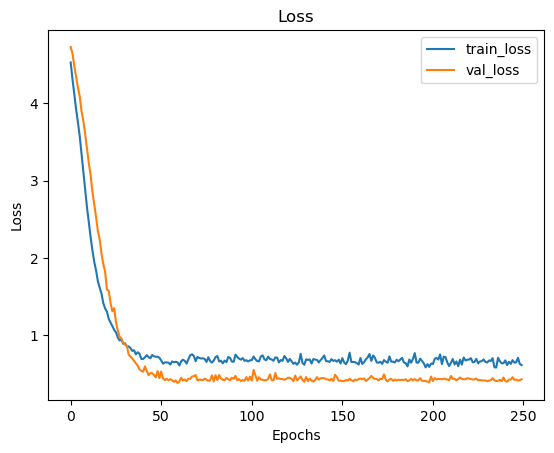

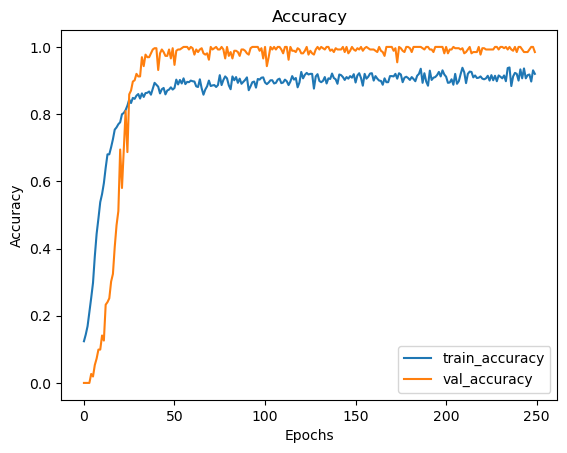

In [48]:
visualize_training_results(model_2_reg_results_opt)

In [34]:
import string

def clean_text(sentence):
    lower = sentence.lower()
    toks = word_tokenize(lower)
    stop_words = set(stopwords.words('english'))
    toks = [word for word in toks if word not in ignoreLetters]
    sentence = [word for word in sentence if word not in stop_words]
    print(f"toks: {toks}\n")
    return toks
    
# test
clean_text("Remove punctuations and return lemmatized tokens ?")

toks: ['remove', 'punctuations', 'and', 'return', 'lemmatized', 'tokens']



['remove', 'punctuations', 'and', 'return', 'lemmatized', 'tokens']

In [35]:
classes

{'Cloud Computing',
 'Contacts',
 'Cybersecurity',
 'Data Science',
 'DevOps',
 'Enrollment',
 'Miscellaneous',
 'Mobile Development',
 'Software Engineering',
 'UI/UX'}

In [37]:
# vectorized_txt

In [51]:
# example
text = "What is the fundamental starting point for understanding Cloud Computing ?"

prep_text = clean_text(text)
vectorized_txt = vectorizer.transform(prep_text)

pred = model_2_reg_opt.predict([vectorized_txt])

ERR_THRESH = 0.25

unique_labels = qna_df["tags"].unique()

results = {np.argmax(r): r[np.argmax(r)] for i, r in enumerate(pred) if any(r > ERR_THRESH)}
results = dict(sorted(results.items(), key=lambda k: k[0]))

print(f"\nPredicted classes: {results}")
for class_key, conf in results.items():
    print(f"{class_key}: {label_encoder.classes_[class_key]}, {round(conf*100)}%")

toks: ['what', 'is', 'the', 'fundamental', 'starting', 'point', 'for', 'understanding', 'cloud', 'computing']

1/1 [==============================] - 0s 4ms/step

Predicted classes: {0: 1.0, 4: 0.4288708, 5: 0.50821084, 6: 0.41610584}
0: Cloud Computing, 100%
4: DevOps, 43%
5: Enrollment, 51%
6: Miscellaneous, 42%


In [50]:
model_2_reg_opt.save("chatbot.model")

INFO:tensorflow:Assets written to: chatbot.model/assets
